I made two tweaks to prev best public notebbok https://www.kaggle.com/code/satyaprakashshukl/kaggle-llm-science by @satyaprakashshukl :

*     how to create text from promt to select pages (retrivial part)
*     softmax for ensemble predictions

More details in comments

<div class="alert alert-success"> 
        <h1 align="center" style="color:chocolate;">Science Question & Answer</h1>  
     
</div>

<div class="alert alert-success"> 
        <h1 align="center" style="color:chocolate;">Thank you Radek for Dataset https://www.kaggle.com/datasets/radek1/additional-train-data-for-llm-science-exam</h1>  
     
</div>

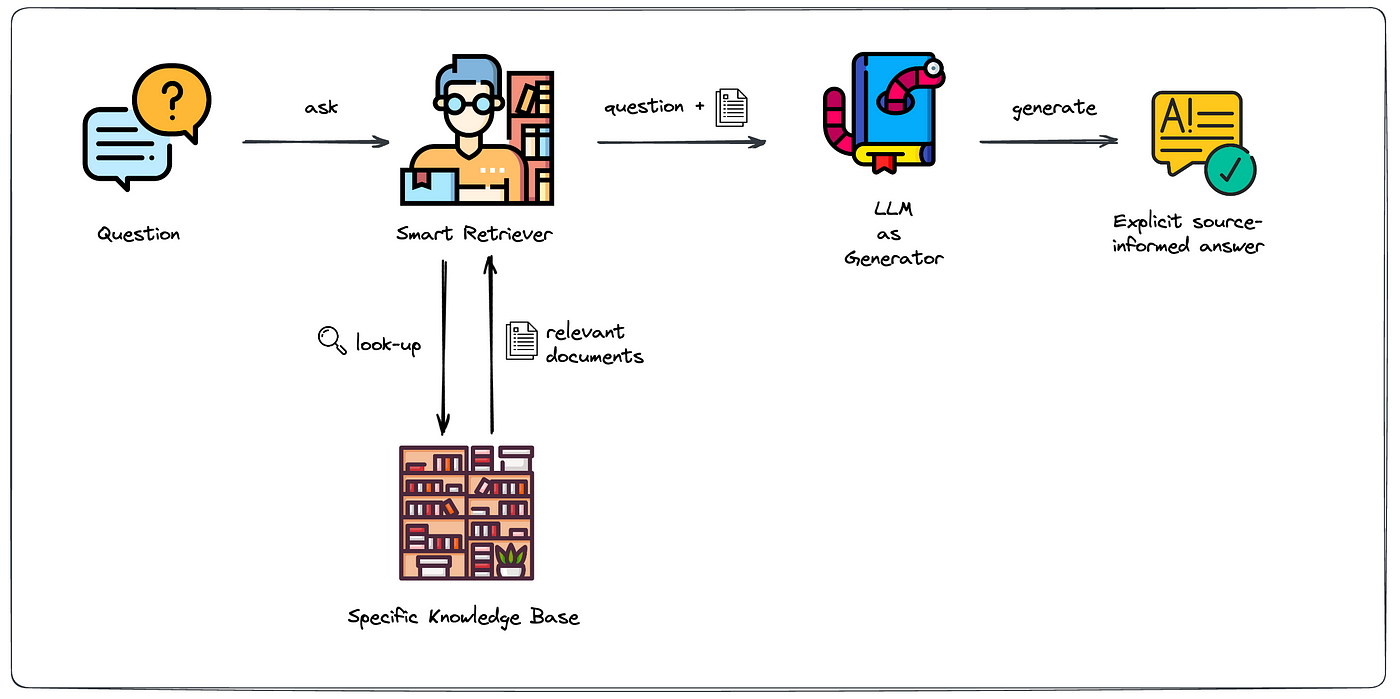

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #7FFFD4; font-size:100%; text-align:left">

<h3 align="center"><font color='#DAA520'>💡 About The Competition :</font></h3>
    
🎭Inspired by the OpenBookQA dataset, this competition challenges participants to answer difficult science-based questions written by a Large Language Model.
🧨This work will help researchers better understand the ability of LLMs to test themselves, and the potential of LLMs that can be run in resource-constrained environments.

🥽This competition involves answering multiple-choice questions generated by an LLM (Legal Language Model).
    
🎍The provided dataset includes 200 sample questions with answers to demonstrate the question format and provide a sense of the test set.
    
🎁It is important to build solutions that can generalize well to a wide range of questions, as there may be a distributional shift between the sample questions and the hidden test set.
    
👓The test set contains around 4000 questions, which may cover different subject matters compared to the sample questions provided.

<div class="alert alert-success">  
    <h1 align="center" style="color:darkgoldenrod;">Importing Libraries</h1>  
     
</div>

In [1]:
!pip install -U /kaggle/input/faiss-gpu-173-python310/faiss_gpu-1.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
!cp -rf /kaggle/input/sentence-transformers-222/sentence-transformers /kaggle/working/sentence-transformers
!pip install -U /kaggle/working/sentence-transformers
!pip install -U /kaggle/input/blingfire-018/blingfire-0.1.8-py3-none-any.whl

!pip install --no-index --no-deps /kaggle/input/llm-whls/transformers-4.31.0-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/llm-whls/peft-0.4.0-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/llm-whls/datasets-2.14.3-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/llm-whls/trl-0.5.0-py3-none-any.whl

Processing /kaggle/input/faiss-gpu-173-python310/faiss_gpu-1.7.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
Processing ./sentence-transformers
  Preparing metadata (setup.py) ... - \ done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=126134 sha256=37ae416b2d3c02ec17f47c3fc0e7ceb445473c6bc1ac1e151f08ee60afc3ffe0
  Stored in directory: /root/.cache/pip/wheels/6c/ea/76/d9a930b223b1d3d5d6aff69458725316b0fe205b854faf1812
Successfully built sentence-transformers
Processing /kaggle/input/blingfire-018/blingfire-0.1.8-py3-none-any.whl
Processing /kaggle/input/llm-whls/transformers-4.31.0-py3-none-any.whl
  Attempting uninstall: transformers
    Found existing installation: transformers 4.30.2
    Uninstalling transformers-4.30.2:
      Successfully uninstalled transformers-4.30.2
Processing /kaggle/input/llm-whls/peft-0.4.0-py3-none-any.whl
Processing /kaggle/input/llm-whls/datasets-2.14.3-py3-none-any.whl
  Attempting

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #7FFFD4; font-size:100%; text-align:left">

<h3 align="center"><font color='#DAA520'>💡 About ThePackages :</font></h3>
    
🎭we are installing several Python packages from local .whl files. This is a common approach when working offline or when you need to install packages that are not available via the standard package repositories. 
    
🧨The faiss-gpu package from the specified .whl file.


🥽The sentence-transformers package from the specified directory.

    
🎍The blingfire package from the specified .whl file.
    
🎁Several packages (transformers, peft, datasets, and trl) from the specified .whl files without checking for dependencies or fetching packages from the internet.


In [2]:
import os
import gc
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import blingfire as bf
from __future__ import annotations
from collections.abc import Iterable
import faiss
from faiss import write_index, read_index
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

import torch
import ctypes
libc = ctypes.CDLL("libc.so.6")
from dataclasses import dataclass
from typing import Optional, Union
from datasets import Dataset
from transformers import AutoTokenizer
from transformers import AutoModelForMultipleChoice, TrainingArguments, Trainer
from transformers.tokenization_utils_base import PreTrainedTokenizerBase, PaddingStrategy
from torch.utils.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
df_train = pd.read_csv('/kaggle/input/kaggle-llm-science-exam/train.csv')
df_test  = pd.read_csv('/kaggle/input/kaggle-llm-science-exam/test.csv')
df_samp = pd.read_csv('/kaggle/input/kaggle-llm-science-exam/sample_submission.csv')
df_extra = pd.read_csv('/kaggle/input/additional-train-data-for-llm-science-exam/extra_train_set.csv')
df_extra_RO = pd.read_csv('/kaggle/input/additional-train-data-for-llm-science-exam/6000_train_examples.csv')

In [4]:
# We have two dataframes named df_train and df_extra with the same number of rows
# Concatenate them
concatenated_df = pd.concat([df_train])
df_train.reset_index(inplace=True, drop=True)
df_train.shape

(200, 8)

In [5]:
import random
import pandas as pd
from transformers import pipeline, AutoTokenizer

# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/bert-base-uncased")

# Initialize the pipeline for masked language modeling using BERT
mlm_fill_mask = pipeline(task="fill-mask", model="/kaggle/input/bert-base-uncased")

# Function to perform data augmentation using different techniques
def augment_data(original_df, num_augmented_rows):
    augmented_data = []
    original_rows = original_df.shape[0]

    # Function for contextual word embeddings augmentation
    def contextual_embeddings(text):
        # Tokenize the text
        tokenized_text = tokenizer(text, return_tensors="pt")

        # Find masked positions in the tokenized text
        masked_positions = [i for i, token in enumerate(tokenized_text["input_ids"][0]) if token == tokenizer.mask_token_id]

        # If no masked positions found, return the original text
        if not masked_positions:
            return text

        # Randomly select one of the masked positions
        random_masked_position = random.choice(masked_positions)

        # Predict the masked word using masked language modeling
        masked_text = text.replace("[MASK]", tokenizer.mask_token)
        predicted_word = mlm_fill_mask(masked_text)[0]["token_str"]

        # Replace the masked word in the text with the predicted word
        augmented_text = text.replace(tokenizer.mask_token, predicted_word, 1)

        return augmented_text

    # Function for synonym replacement augmentation
    def augment_with_synonyms(text):
        # You can use your own synonym replacement logic here
        # For simplicity, let's assume we have a predefined dictionary of synonyms
        synonym_dict = {
            "good": ["excellent", "great", "superb", "fine"],
            "bad": ["poor", "terrible", "awful", "horrible"]
            # Add more synonyms as needed
        }

        words = text.split()
        augmented_words = [synonym_dict[word][random.randint(0, len(synonym_dict[word]) - 1)] if word in synonym_dict else word for word in words]
        return " ".join(augmented_words)

    for _ in range(num_augmented_rows):
        original_row = original_df.iloc[random.randint(0, original_rows - 1)]
        augmented_row = original_row.copy()

        # Apply augmentation techniques to "prompt"
        augmented_row["prompt"] = contextual_embeddings(original_row["prompt"])

        # Apply synonym replacement to answer choices (A, B, C, D, E)
        for choice in ["A", "B", "C", "D", "E"]:
            augmented_row[choice] = augment_with_synonyms(original_row[choice])

        augmented_data.append(augmented_row)

    return augmented_data

# Assuming you have a concatenated_df dataframe with columns: "prompt", "A", "B", "C", "D", "E", and "answer"
# Set the desired number of rows
desired_rows = 500

# Calculate the number of rows needed to achieve the desired total rows
additional_rows = desired_rows - concatenated_df.shape[0]

# Augment the data
augmented_data = augment_data(concatenated_df, additional_rows)

# Convert the augmented data to a dataframe
augmented_df = pd.DataFrame(augmented_data)

# Concatenate the original dataframe with the augmented dataframe to get the final dataframe with 3000 rows
final_df = pd.concat([concatenated_df, augmented_df], ignore_index=True)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #F08080; font-size:100%; text-align:left">

<h3 align="center"><font color='#000000'>💡Categorical Columns:</font></h3>
    
🎡🎠🎁From The training Dataset one can see we have a query and specific to that query there are 5 available option, although for trainig dataset a choice has been made, if we see the first query and there corrrespoding answers are D, A, A and C, so here we can use the pretrained model and make some prediction using training data itself and see how well the pre-trained model are prforming, then one can test it on test dataset .....🎪🎁🎇Lets Begin the Journey 🎏✨🧨

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #92a8d1; font-size:150%; text-align:center">

<h3 align="centre"><font color='#fefbd8'>💡Plotting The Data:</font></h3>
    
🎁All the Dataset are categorical in nature🎨🧨
    
 🕶👓Lets Check out some plot and what they got to say about the complexity of Dataset
    
We are going to use wordcloud in the word cloud, words are typically presented in a random arrangement, and their sizes are proportional to their frequency or importance. Frequently occurring words are usually displayed with larger fonts or sizes, while less common words appear smaller.
    
It can help identify patterns, key terms, or trends within a large body of text.

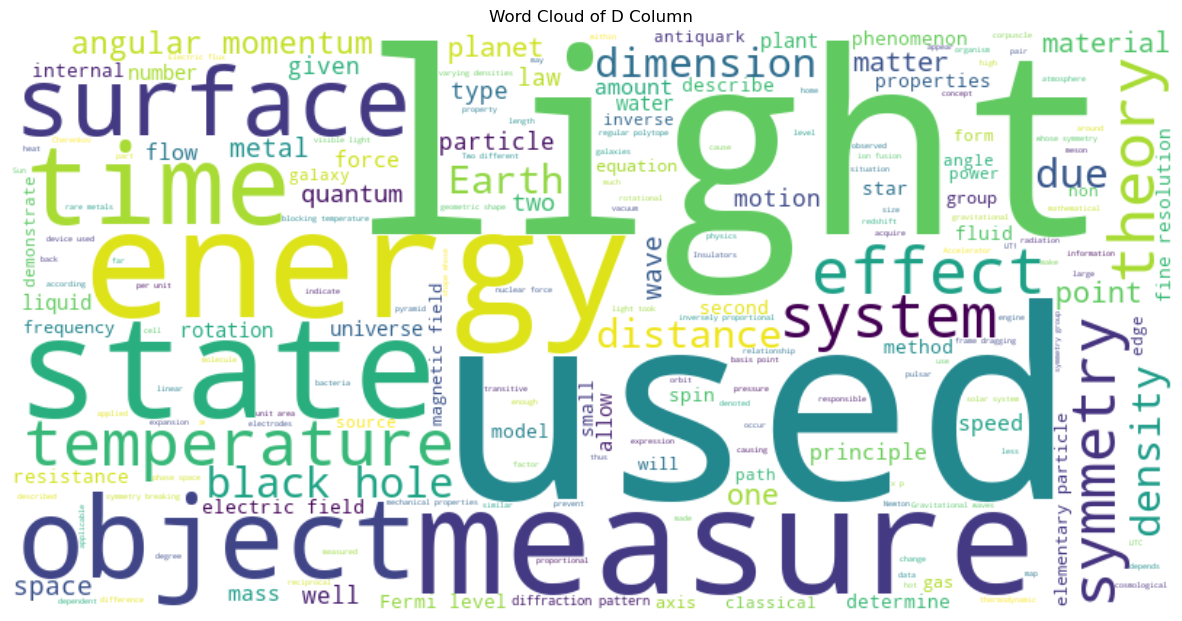

In [6]:
from wordcloud import WordCloud

# Concatenate the sentences into a single string
text_data = ' '.join(final_df['D'])

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Plot the word cloud
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of D Column')
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #7FFFD4; font-size:100%; text-align:left">

<h3 align="center"><font color='#DAA520'>💡 Observation from above plot :</font></h3>
    
🎭 We can see from above plots some words are quite often repated in all the option one can say the options are mostly same or little difference occur between them so to choose best option we can also explore a metric listed below    
    
🎎Cosine Similarity: Measures the similarity in direction between two sentence vectors.
    
🎪Jaccard Similarity: Calculates the proportion of shared words between two sentences.
    
🦺Levenshtein Distance: Quantifies the minimum number of operations needed to transform one sentence into another.
    
🧨Word Embedding Distance: Compares sentence vectors using similarity measures like cosine or Euclidean distance.
    
🎃BERT-based Embedding Distance: Measures similarity between sentences using BERT-based contextualized embeddings.
    
🎊ROUGE: Evaluates overlap between sentences using n-gram matching, commonly used in summarization and translation tasks.
    
 Lets Do some Check with cosine Similarity but before that lets explore further about the data


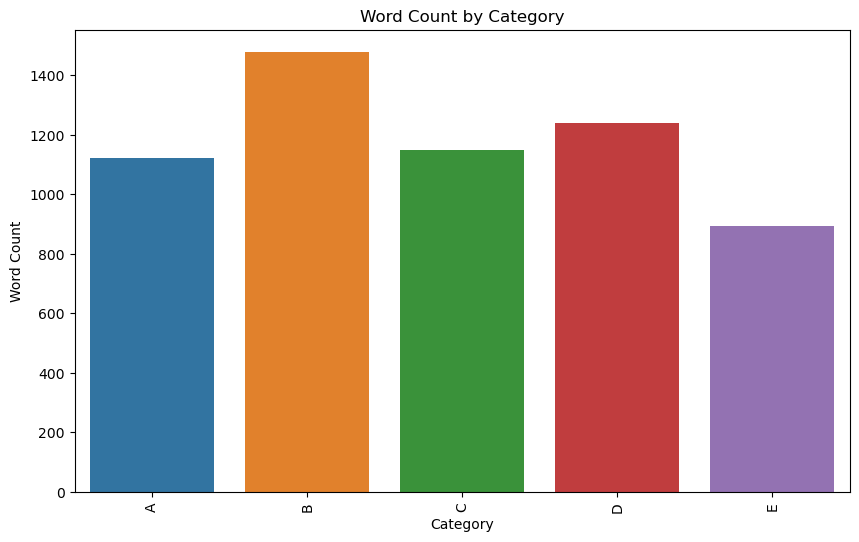

In [7]:
import seaborn as sns

# Calculate the word count by category
category_word_count = final_df.groupby('answer')['prompt'].apply(lambda x: ' '.join(x)).str.split().apply(len)

# Plot the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=category_word_count.index, y=category_word_count.values)
plt.xlabel('Category')
plt.ylabel('Word Count')
plt.title('Word Count by Category')
plt.xticks(rotation=90)
plt.show()

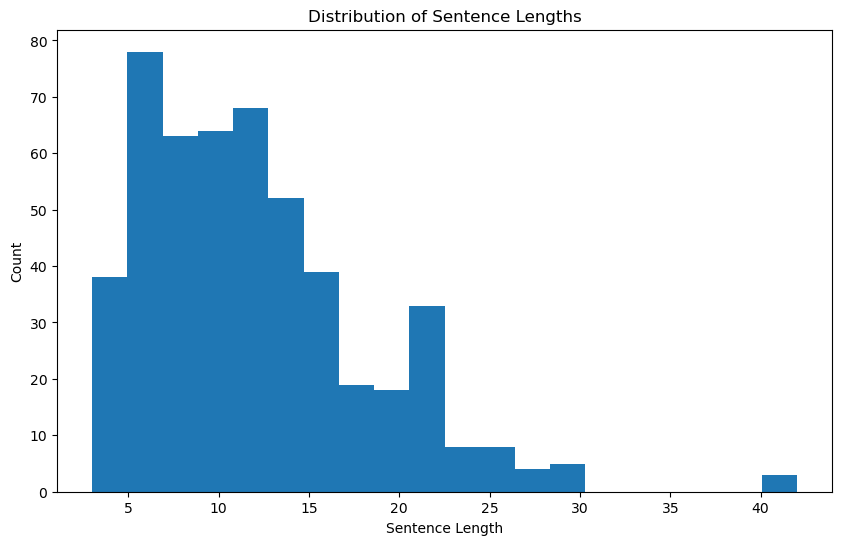

In [8]:
# Calculate the lengths of each sentence
sentence_lengths = final_df['prompt'].str.split().apply(len)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(sentence_lengths, bins=20)
plt.xlabel('Sentence Length')
plt.ylabel('Count')
plt.title('Distribution of Sentence Lengths')
plt.show()

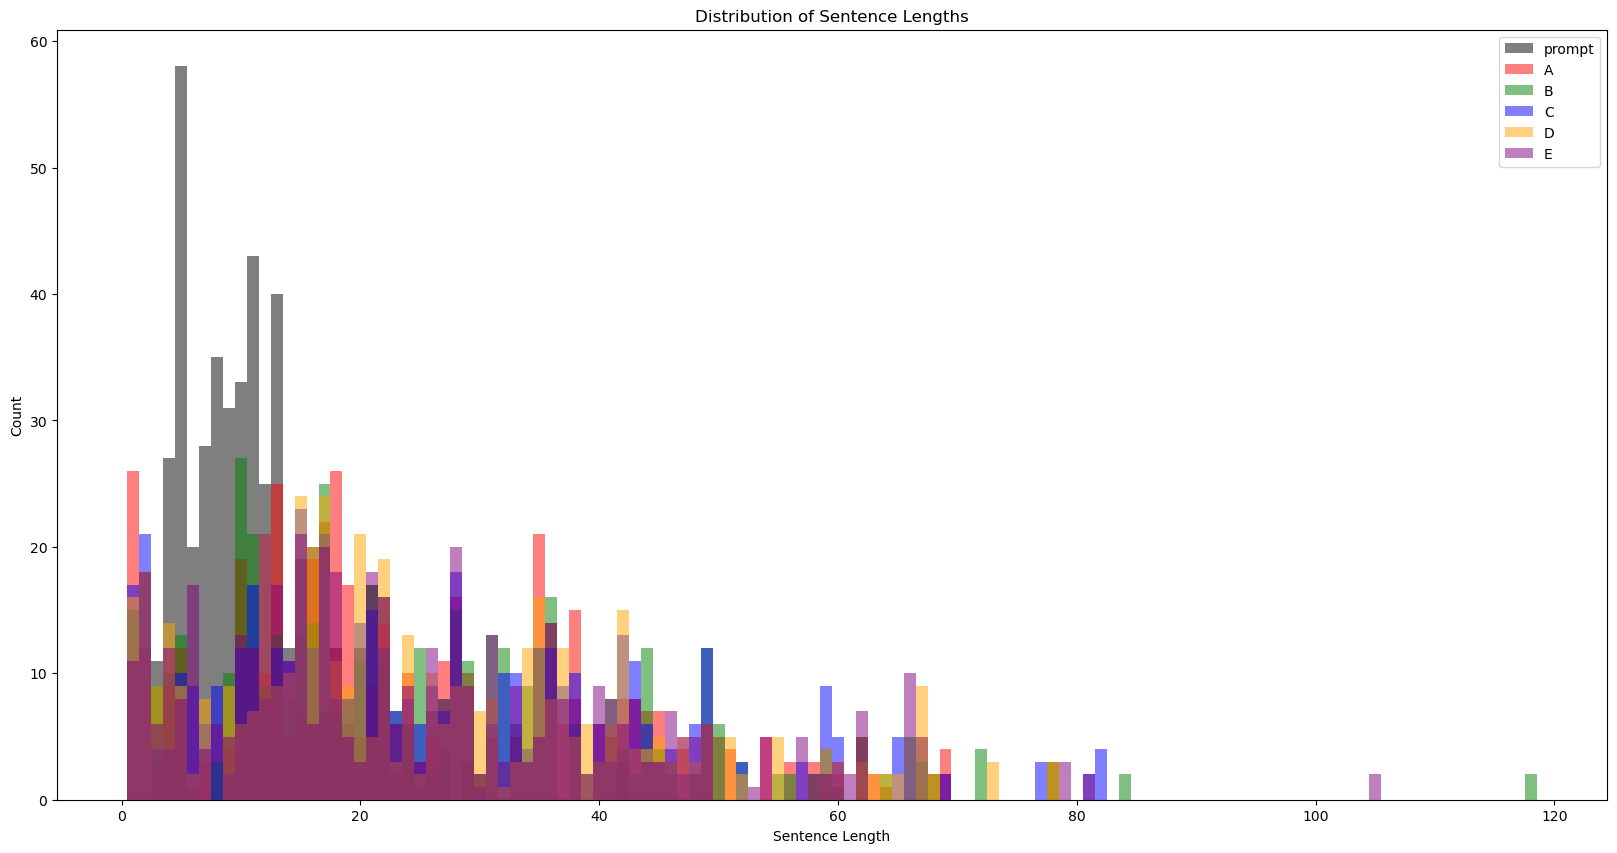

In [9]:
# Calculate the lengths of each sentence for columns A, B, C, D, E
columns = ['prompt','A', 'B', 'C', 'D', 'E']
sentence_lengths = {}
for col in columns:
    sentence_lengths[col] = final_df[col].str.split().apply(len)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(20, 10))

# Set up color palette
colors = ['black','red', 'green', 'blue', 'orange', 'purple']

# Plot the histograms side by side
for i, col in enumerate(columns):
    bins = np.arange(min(sentence_lengths[col]), max(sentence_lengths[col])+2) - 0.5
    ax.hist(sentence_lengths[col], bins=bins, color=colors[i], alpha=0.5, label=col)

# Customize the plot
ax.set_xlabel('Sentence Length')
ax.set_ylabel('Count')
ax.set_title('Distribution of Sentence Lengths')
ax.legend()

# Show the plot
plt.show()


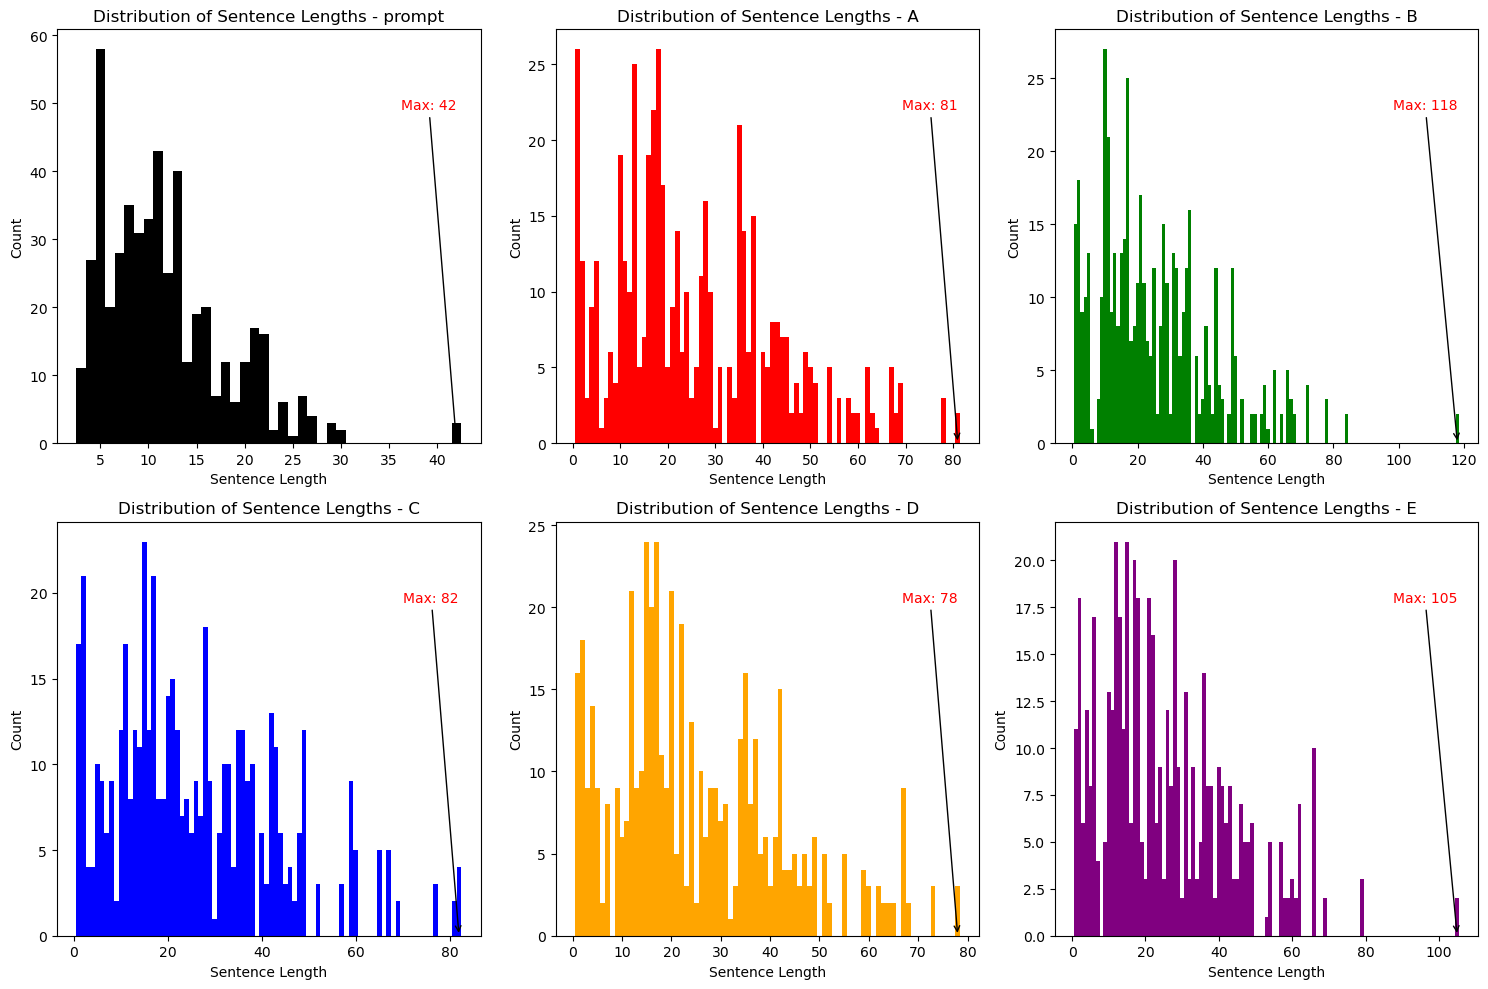

In [10]:
# Calculate the lengths of each sentence for columns A, B, C, D, E
columns = ['prompt','A', 'B', 'C', 'D', 'E']
colors = ['black','red', 'green', 'blue', 'orange', 'purple']

# Set up the figure and axes
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot the histograms for each column with different colors and annotate the maximum value
for i, col in enumerate(columns):
    bins = np.arange(min(final_df[col].str.split().apply(len)), max(final_df[col].str.split().apply(len))+2) - 0.5
    axes[i].hist(final_df[col].str.split().apply(len), bins=bins, color=colors[i])
    axes[i].set_xlabel('Sentence Length')
    axes[i].set_ylabel('Count')
    axes[i].set_title(f'Distribution of Sentence Lengths - {col}')
    max_length = final_df[col].str.split().apply(len).max()
    axes[i].annotate(f'Max: {max_length}', xy=(max_length, 0), xytext=(max_length, 0.8 * axes[i].get_ylim()[1]),
                     color='red', ha='right', va='bottom', arrowprops=dict(arrowstyle='->'))

# Remove any unused subplots
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


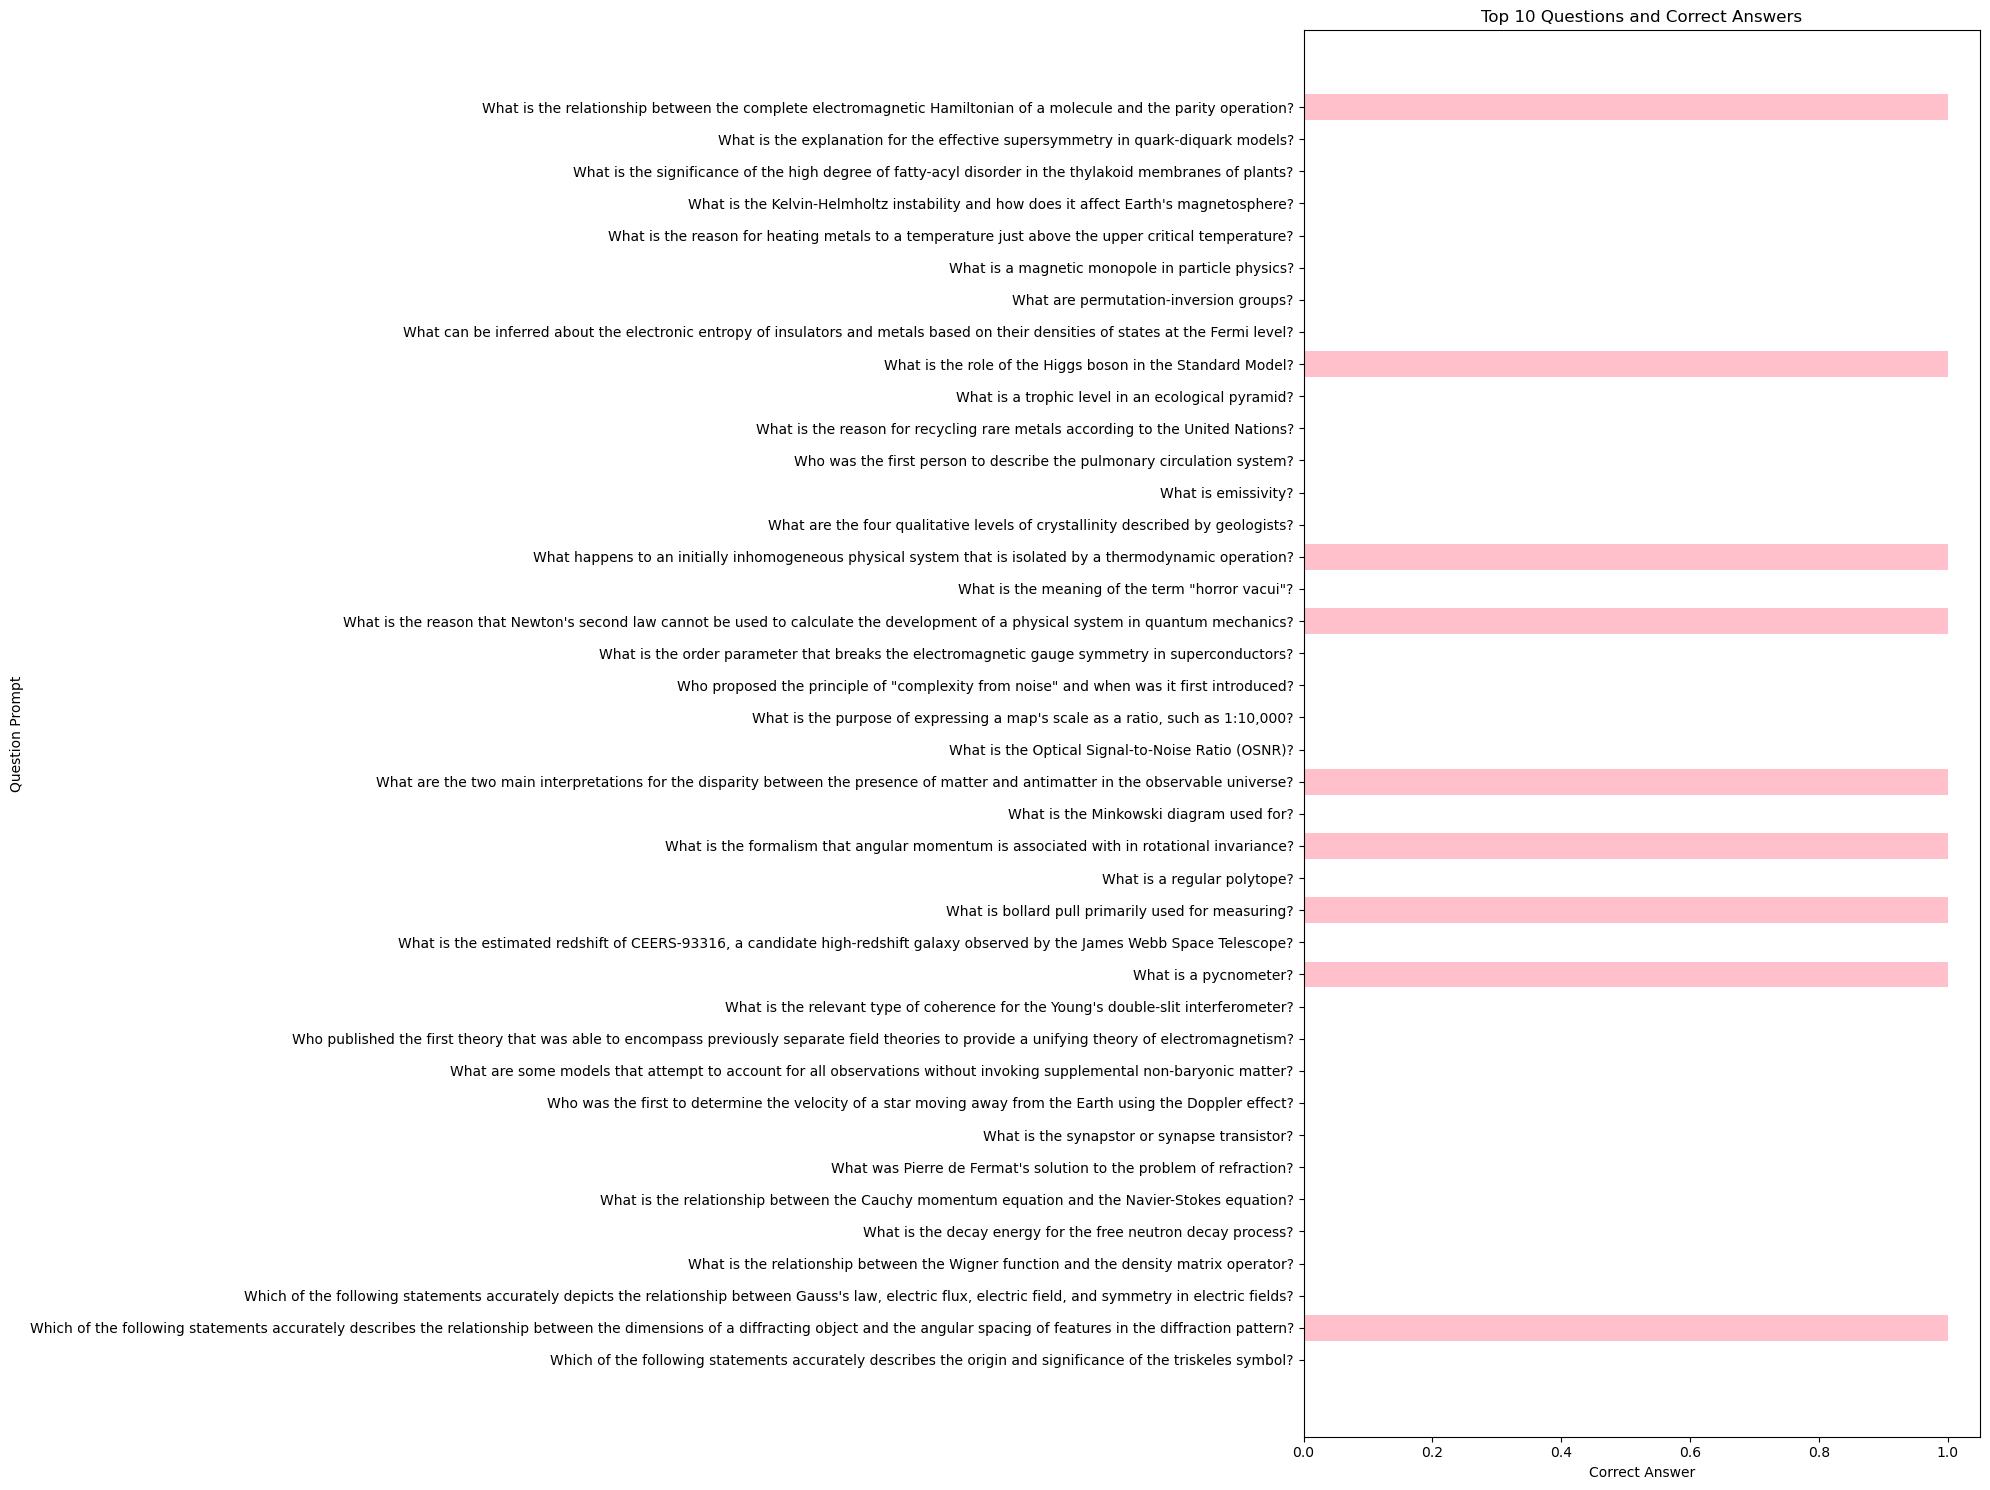

In [11]:
# Get the top 10 prompts based on the number of occurrences
top_prompts = final_df['prompt'].value_counts().nlargest(40).index

# Filter the DataFrame to include only the top prompts
df_top_prompts = final_df[final_df['prompt'].isin(top_prompts)]

# Create a horizontal bar plot
fig, ax = plt.subplots(figsize=(20, 15))

# Set the y-axis labels as the prompt
y = df_top_prompts['prompt']

# Set the x-axis labels as the correct answer (A, B, C, D, E)
x = df_top_prompts['answer'].map(lambda ans: 1 if ans == 'D' else 0)

# Plot the horizontal bar plot
ax.barh(y, x, color=['pink' if ans == 'D' else 'blue' for ans in df_top_prompts['answer']])

# Customize the plot
ax.set_yticklabels(y)
ax.set_xlabel('Correct Answer')
ax.set_ylabel('Question Prompt')
ax.set_title('Top 10 Questions and Correct Answers')

plt.tight_layout()
plt.show()

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #7FFFD4; font-size:100%; text-align:left">

<h3 align="center"><font color='#DAA520'>💡 Observation from above plot :</font></h3>
    
🎍🎎 Majority of Distribution for the senetce length for all options lies between 0 to 40 and from greater than 40 length of sentence occurence is less and we can see form the prompt distribution ✨🎊🧨
    
<h3 align="center"><font color='#DAA520'>💡 Inference from horizonatal bar plot from some top question :</font></h3>
   
    Let see if there exsit any pattern between question and answer, from the bar plot we can try to analyze it.
    if any pattern exsist from prompt to answer then one can also group them in one frame or one part. 
    Got to inference those plot ........work in progress


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #7FFFD4; font-size:100%; text-align:left">

<h3 align="center"><font color='#DAA520'>💡 About The Process Documents :</font></h3>
    
🎭Input Documents: The function takes a collection of input documents as an iterable of strings.. 
    
🧨Document IDs: It also requires corresponding document identifiers or labels as an iterable..


🥽Sentence Splitting: There's an option to split the input documents into sentences. If enabled, it further processes the text.

    
🎍Minimum Sentence Length: An integer parameter, filter_len, can be set to control the minimum length of sentences. Short sentences may be filtered out.
    
🎁Structured Output: The function returns the processed data as a Pandas DataFrame, which can be useful for organizing and analyzing document-level data.
    
🎠🧛🏽‍♂️This function is designed to facilitate document preprocessing and sentence-level analysis, making it adaptable for various natural language processing tasks.🙏🏽🐱

In [12]:
def process_documents(documents: Iterable[str],
                      document_ids: Iterable,
                      split_sentences: bool = True,
                      filter_len: int = 9,
                      disable_progress_bar: bool = False) -> pd.DataFrame:
    """
    Main helper function to process documents from the EMR.

    :param documents: Iterable containing documents which are strings
    :param document_ids: Iterable containing document unique identifiers
    :param document_type: String denoting the document type to be processed
    :param document_sections: List of sections for a given document type to process
    :param split_sentences: Flag to determine whether to further split sections into sentences
    :param filter_len: Minimum character length of a sentence (otherwise filter out)
    :param disable_progress_bar: Flag to disable tqdm progress bar
    :return: Pandas DataFrame containing the columns `document_id`, `text`, `section`, `offset`
    """
    
    df = sectionize_documents(documents, document_ids, disable_progress_bar)

    if split_sentences:
        df = sentencize(df.text.values, 
                        df.document_id.values,
                        df.offset.values, 
                        filter_len, 
                        disable_progress_bar)
    return df

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #7FFFD4; font-size:100%; text-align:left">

<h3 align="center"><font color='#DAA520'>💡 About The sectionize_documents :</font></h3>
    
🎭 Obtains the sections of the imaging reports and returns only the 
    selected sections (defaults to FINDINGS, IMPRESSION, and ADDENDUM) 
    
🧨param documents: Iterable containing documents which are strings

🥽param document_ids: Iterable containing document unique identifiers
    
🎍:param disable_progress_bar: Flag to disable tqdm progress bar
    
🎁return: Pandas DataFrame containing the columns `document_id`, `text`, `offset`   


In [13]:
def sectionize_documents(documents: Iterable[str],
                         document_ids: Iterable,
                         disable_progress_bar: bool = False) -> pd.DataFrame:
    """
    Obtains the sections of the imaging reports and returns only the 
    selected sections (defaults to FINDINGS, IMPRESSION, and ADDENDUM).

    :param documents: Iterable containing documents which are strings
    :param document_ids: Iterable containing document unique identifiers
    :param disable_progress_bar: Flag to disable tqdm progress bar
    :return: Pandas DataFrame containing the columns `document_id`, `text`, `offset`
    """
    processed_documents = []
    for document_id, document in tqdm(zip(document_ids, documents), total=len(documents), disable=disable_progress_bar):
        row = {}
        text, start, end = (document, 0, len(document))
        row['document_id'] = document_id
        row['text'] = text
        row['offset'] = (start, end)

        processed_documents.append(row)

    _df = pd.DataFrame(processed_documents)
    if _df.shape[0] > 0:
        return _df.sort_values(['document_id', 'offset']).reset_index(drop=True)
    else:
        return _df

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #7FFFD4; font-size:100%; text-align:left">

<h3 align="center"><font color='#DAA520'>💡 About The sectionize_documents :</font></h3>
    
🎭 Split a document into sentences. Can be used with `sectionize_documents`to further split documents into more manageable pieces. 
    
🧨Takes in offsets to ensure that after splitting, the sentences can be matched to the  location in the original documents. 

🥽:param documents: Iterable containing documents which are strings
🎎:param document_ids: Iterable containing document unique identifiers
🔐:param offsets: Iterable tuple of the start and end indices
🎆:param filter_len: Minimum character length of a sentence (otherwise filter out)
🎡:return: Pandas DataFrame containing the columns `document_id`, `text`, `section`, `offset 

In [14]:
def sentencize(documents: Iterable[str],
               document_ids: Iterable,
               offsets: Iterable[tuple[int, int]],
               filter_len: int = 9,
               disable_progress_bar: bool = False) -> pd.DataFrame:
    """
    Split a document into sentences. Can be used with `sectionize_documents`
    to further split documents into more manageable pieces. Takes in offsets
    to ensure that after splitting, the sentences can be matched to the
    location in the original documents.

    :param documents: Iterable containing documents which are strings
    :param document_ids: Iterable containing document unique identifiers
    :param offsets: Iterable tuple of the start and end indices
    :param filter_len: Minimum character length of a sentence (otherwise filter out)
    :return: Pandas DataFrame containing the columns `document_id`, `text`, `section`, `offset`
    """

    document_sentences = []
    for document, document_id, offset in tqdm(zip(documents, document_ids, offsets), total=len(documents), disable=disable_progress_bar):
        try:
            _, sentence_offsets = bf.text_to_sentences_and_offsets(document)
            for o in sentence_offsets:
                if o[1]-o[0] > filter_len:
                    sentence = document[o[0]:o[1]]
                    abs_offsets = (o[0]+offset[0], o[1]+offset[0])
                    row = {}
                    row['document_id'] = document_id
                    row['text'] = sentence
                    row['offset'] = abs_offsets
                    document_sentences.append(row)
        except:
            continue
    return pd.DataFrame(document_sentences)

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #7FFFD4; font-size:100%; text-align:left">

<h3 align="center"><font color='#DAA520'>💡 About The Parameter :</font></h3>
    
🎭 These variables likely play a role in your data processing and modeling tasks such as text embedding generation using the specified model and handling Wikipedia text data. 
    
🧨If you have specific questions or tasks related to these variables, please provide more details, and I'd be happy to assist further. 


In [15]:
SIM_MODEL = '/kaggle/input/sentencetransformers-allminilml6v2/sentence-transformers_all-MiniLM-L6-v2'
DEVICE = 0
MAX_LENGTH = 384
BATCH_SIZE = 32
WIKI_PATH = "/kaggle/input/wikipedia-20230701"
wiki_files = os.listdir(WIKI_PATH)

<div class="alert alert-success">  
    <h1 align="center" style="color:darkcyan;">Reading The Dataset</h1>  
     
</div>

In [16]:
trn = pd.read_csv("/kaggle/input/kaggle-llm-science-exam/test.csv").drop("id", 1)
trn.head()


,prompt,A,B,C,D,E
0,Which of the following statements accurately d...,MOND is a theory that reduces the observed mis...,MOND is a theory that increases the discrepanc...,MOND is a theory that explains the missing bar...,MOND is a theory that reduces the discrepancy ...,MOND is a theory that eliminates the observed ...
1,Which of the following is an accurate definiti...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...,Dynamic scaling refers to the non-evolution of...,Dynamic scaling refers to the evolution of sel...
2,Which of the following statements accurately d...,The triskeles symbol was reconstructed as a fe...,The triskeles symbol is a representation of th...,The triskeles symbol is a representation of a ...,The triskeles symbol represents three interloc...,The triskeles symbol is a representation of th...
3,What is the significance of regularization in ...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...,Regularizing the mass-energy of an electron wi...
4,Which of the following statements accurately d...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...,The angular spacing of features in the diffrac...


In [17]:
## Combine all answers
trn['answer_all'] = trn.apply(lambda x: " ".join([x['A'], x['B'], x['C'], x['D'], x['E']]), axis=1)


## Search using the prompt and answers to guide the search
trn['prompt_answer_stem'] = trn['prompt'] + " " + trn['answer_all']

In [18]:
model = SentenceTransformer(SIM_MODEL, device='cuda')
model.max_seq_length = MAX_LENGTH
model = model.half()

In [19]:
sentence_index = read_index("/kaggle/input/wikipedia-2023-07-faiss-index/wikipedia_202307.index")


In [20]:
prompt_embeddings = model.encode(trn.prompt_answer_stem.values, batch_size=BATCH_SIZE, device=DEVICE, show_progress_bar=True, convert_to_tensor=True, normalize_embeddings=True)
prompt_embeddings = prompt_embeddings.detach().cpu().numpy()
_ = gc.collect()

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [21]:
search_score, search_index = sentence_index.search(prompt_embeddings, 6)

In [22]:
del sentence_index
del prompt_embeddings
_ = gc.collect()
libc.malloc_trim(0)

1

In [23]:
df = pd.read_parquet("/kaggle/input/wikipedia-20230701/wiki_2023_index.parquet",
                     columns=['id', 'file'])

In [24]:
wikipedia_file_data = []

for i, (scr, idx) in tqdm(enumerate(zip(search_score, search_index)), total=len(search_score)):
    scr_idx = idx
    _df = df.loc[scr_idx].copy()
    _df['prompt_id'] = i
    wikipedia_file_data.append(_df)
wikipedia_file_data = pd.concat(wikipedia_file_data).reset_index(drop=True)
wikipedia_file_data = wikipedia_file_data[['id', 'prompt_id', 'file']].drop_duplicates().sort_values(['file', 'id']).reset_index(drop=True)

## Save memory - delete df since it is no longer necessary
del df
_ = gc.collect()
libc.malloc_trim(0)

  0%|          | 0/200 [00:00<?, ?it/s]

1

In [25]:
wiki_text_data = []

for file in tqdm(wikipedia_file_data.file.unique(), total=len(wikipedia_file_data.file.unique())):
    _id = [str(i) for i in wikipedia_file_data[wikipedia_file_data['file']==file]['id'].tolist()]
    _df = pd.read_parquet(f"{WIKI_PATH}/{file}", columns=['id', 'text'])

    _df_temp = _df[_df['id'].isin(_id)].copy()
    del _df
    _ = gc.collect()
    libc.malloc_trim(0)
    wiki_text_data.append(_df_temp)
wiki_text_data = pd.concat(wiki_text_data).drop_duplicates().reset_index(drop=True)
_ = gc.collect()

  0%|          | 0/27 [00:00<?, ?it/s]

In [26]:
processed_wiki_text_data = process_documents(wiki_text_data.text.values, wiki_text_data.id.values)


  0%|          | 0/1120 [00:00<?, ?it/s]

  0%|          | 0/1120 [00:00<?, ?it/s]

In [27]:
wiki_data_embeddings = model.encode(processed_wiki_text_data.text,
                                    batch_size=BATCH_SIZE,
                                    device=DEVICE,
                                    show_progress_bar=True,
                                    convert_to_tensor=True,
                                    normalize_embeddings=True)#.half()
wiki_data_embeddings = wiki_data_embeddings.detach().cpu().numpy()

Batches:   0%|          | 0/1991 [00:00<?, ?it/s]

In [28]:
_ = gc.collect()


In [29]:
question_embeddings = model.encode(trn.prompt_answer_stem.values, batch_size=BATCH_SIZE, device=DEVICE, show_progress_bar=True, convert_to_tensor=True, normalize_embeddings=True)
question_embeddings = question_embeddings.detach().cpu().numpy()

Batches:   0%|          | 0/7 [00:00<?, ?it/s]

In [30]:
## Parameter to determine how many relevant sentences to include
NUM_SENTENCES_INCLUDE = 22

## List containing just Context
contexts = []

for r in tqdm(trn.itertuples(), total=len(trn)):

    prompt_id = r.Index

    prompt_indices = processed_wiki_text_data[processed_wiki_text_data['document_id'].isin(wikipedia_file_data[wikipedia_file_data['prompt_id']==prompt_id]['id'].values)].index.values

    if prompt_indices.shape[0] > 0:
        prompt_index = faiss.index_factory(wiki_data_embeddings.shape[1], "Flat")
        prompt_index.add(wiki_data_embeddings[prompt_indices])

        context = ""
        
        ## Get the top matches
        ss, ii = prompt_index.search(question_embeddings, NUM_SENTENCES_INCLUDE)
        for _s, _i in zip(ss[prompt_id], ii[prompt_id]):
            context += processed_wiki_text_data.loc[prompt_indices]['text'].iloc[_i] + " "
        
    contexts.append(context)

  0%|          | 0/200 [00:00<?, ?it/s]

In [31]:
trn['context'] = contexts


In [32]:
trn[["prompt", "context", "A", "B", "C", "D", "E"]].to_csv("./test_context.csv", index=False)

In [33]:
test_df = pd.read_csv("test_context.csv")
test_df.index = list(range(len(test_df)))
test_df['id'] = list(range(len(test_df)))
test_df["prompt"] = test_df["context"].apply(lambda x: x[:2100]) + " #### " +  test_df["prompt"]
test_df['answer'] = 'A'

In [34]:
model_dir = "/kaggle/input/llm-science-run-context-2"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForMultipleChoice.from_pretrained(model_dir).cuda()
model.eval()

DebertaV2ForMultipleChoice(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_aff

In [35]:
# We'll create a dictionary to convert option names (A, B, C, D, E) into indices and back again
options = 'ABCDE'
indices = list(range(5))

option_to_index = {option: index for option, index in zip(options, indices)}
index_to_option = {index: option for option, index in zip(options, indices)}

def preprocess(example):
    # The AutoModelForMultipleChoice class expects a set of question/answer pairs
    # so we'll copy our question 5 times before tokenizing
    first_sentence = [example['prompt']] * 5
    second_sentence = []
    for option in options:
        second_sentence.append(example[option])
    # Our tokenizer will turn our text into token IDs BERT can understand
    tokenized_example = tokenizer(first_sentence, second_sentence, truncation=True)
    tokenized_example['label'] = option_to_index[example['answer']]
    return tokenized_example

In [36]:
@dataclass
class DataCollatorForMultipleChoice:
    tokenizer: PreTrainedTokenizerBase
    padding: Union[bool, str, PaddingStrategy] = True
    max_length: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    
    def __call__(self, features):
        label_name = "label" if 'label' in features[0].keys() else 'labels'
        labels = [feature.pop(label_name) for feature in features]
        batch_size = len(features)
        num_choices = len(features[0]['input_ids'])
        flattened_features = [
            [{k: v[i] for k, v in feature.items()} for i in range(num_choices)] for feature in features
        ]
        flattened_features = sum(flattened_features, [])
        
        batch = self.tokenizer.pad(
            flattened_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors='pt',
        )
        batch = {k: v.view(batch_size, num_choices, -1) for k, v in batch.items()}
        batch['labels'] = torch.tensor(labels, dtype=torch.int64)
        return batch

In [37]:
tokenized_test_dataset = Dataset.from_pandas(test_df[['id', 'prompt', 'A', 'B', 'C', 'D', 'E', 'answer']].drop(columns=['id'])).map(preprocess, remove_columns=['prompt', 'A', 'B', 'C', 'D', 'E', 'answer'])
tokenized_test_dataset = tokenized_test_dataset.remove_columns(["__index_level_0__"])
data_collator = DataCollatorForMultipleChoice(tokenizer=tokenizer)
test_dataloader = DataLoader(tokenized_test_dataset, batch_size=1, shuffle=False, collate_fn=data_collator)

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [38]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / e_x.sum(axis=-1, keepdims = True)    

In [39]:
%%time

test_predictions = []
for batch in test_dataloader:
    for k in batch.keys():
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(**batch)
    test_predictions.append(outputs.logits.cpu().detach())

test_predictions = torch.cat(test_predictions)
test_predictions = test_predictions.numpy()

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


CPU times: user 1min 21s, sys: 61.6 ms, total: 1min 21s
Wall time: 1min 21s


In [40]:
%%time

model_dir = "/kaggle/input/how-to-train-open-book-model-part-1/model_v2/"
tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForMultipleChoice.from_pretrained(model_dir).cuda()
model.eval()

CPU times: user 4.23 s, sys: 1.94 s, total: 6.16 s
Wall time: 21.1 s


DebertaV2ForMultipleChoice(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_aff

In [41]:
test_predictions2 = []
for batch in test_dataloader:
    for k in batch.keys():
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(**batch)
    test_predictions2.append(outputs.logits.cpu().detach())

test_predictions2 = torch.cat(test_predictions2)
test_predictions2 = test_predictions2.numpy()

test_predictions = softmax (test_predictions) + softmax(test_predictions2)

predictions_as_ids = np.argsort(-test_predictions, 1)

predictions_as_answer_letters = np.array(list('ABCDE'))[predictions_as_ids]
# predictions_as_answer_letters[:3]

predictions_as_string = test_df['prediction'] = [
    ' '.join(row) for row in predictions_as_answer_letters[:, :3]
]

In [42]:
submission = test_df[['id', 'prediction']]
submission.to_csv('submission.csv', index=False)

<div class="alert alert-success"> 
        <h1 align="center" style="color:chocolate;">Looking Forward for feeback </h1>  
     
</div>

Thanks to https://www.kaggle.com/code/mewmlelswm/interesting-combination-of-average-experiments/notebook

          https://www.kaggle.com/code/cdeotte/how-to-train-open-book-model-part-2